In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import json
import wandb
import dfs_code
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
sys.path = ['../../src'] + sys.path
from dfs_transformer import DFSCodeSeq2SeqFC, TrainerNew, PubChem, get_n_files, TransformerPlusHeads
from dfs_transformer.training.utils import seq_loss, seq_acc, collate_BERT, collate_rnd2min
import argparse
import yaml
import functools
from ml_collections import ConfigDict
from copy import deepcopy
import pickle
from sklearn.metrics import r2_score
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2*2048, rlimit[1]))
#torch.multiprocessing.set_sharing_strategy('file_system')



args = ConfigDict({
    'yaml_model':"../../config/selfattn/model/bert.yaml",
    'yaml_data':"../../config/selfattn/data/pubchem1M.yaml",
    'yaml_training':"../../config/selfattn/training/min2min_new.yaml"
})

config = ConfigDict({'model':{}, 'data':{}, 'training':{}})
with open(args.yaml_model) as file:
    config.model = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))
with open(args.yaml_data) as file:
    config.data = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))
with open(args.yaml_training) as file:
    config.training = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

m = deepcopy(config.model)
t = deepcopy(config.training)
d = deepcopy(config.data)

device = torch.device('cuda:%d'%config.training.gpu_id if torch.cuda.is_available() else 'cpu')

m['no_features'] = False
m['use_loops'] = False
d.valid_path = "../../results/pubchem/noH/validation/"
d.path = "../../results/pubchem/noH/10K/"
d.molecular_properties = []

config.training.fraction_missing=0.5


if t.mode == "min2min":
    collate_fn = functools.partial(collate_BERT, 
                                   mode="min2min", 
                                   fraction_missing = config.training.fraction_missing,
                                   use_loops=m.use_loops)
elif t.mode == "rnd2rnd":
    collate_fn = functools.partial(collate_BERT, 
                                   mode="rnd2rnd", 
                                   fraction_missing = config.training.fraction_missing,
                                   use_loops=m.use_loops)
elif t.mode == "rnd2min":
    collate_fn = functools.partial(collate_rnd2min,
                                       use_loops=m.use_loops)

validloader = None
if d.valid_path is not None:
    validset = PubChem(d.valid_path, max_nodes=m.max_nodes, max_edges=m.max_edges, noFeatures=m.no_features,
                       molecular_properties=None)
    validloader = DataLoader(validset, batch_size=t.batch_size, shuffle=True, 
                             pin_memory=True, collate_fn=collate_fn)
    exclude = validset.smiles

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9978/9978 [00:01<00:00, 8424.11it/s]


In [8]:
from dfs_transformer import to_cuda as utils_to_cuda
import tqdm
to_cuda = functools.partial(utils_to_cuda, device=device)

In [9]:
dataset = PubChem(d.path, n_used = d.n_used, max_nodes=m.max_nodes, 
                  max_edges=m.max_edges, exclude=exclude, noFeatures=m.no_features,
                  molecular_properties=d.molecular_properties)
loader = DataLoader(dataset, batch_size=t.batch_size, shuffle=True, 
                    pin_memory=t.pin_memory, collate_fn=collate_fn, num_workers=0,#t.num_workers,
                    prefetch_factor=t.prefetch_factor)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 997/997 [00:00<00:00, 8898.28it/s]


In [11]:
data = next(iter(loader))

tensor([[-1, -1, -1, -1, -1, -1, -1, -1],
        [10, 11,  7,  0,  6, 25, 54, 26],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [ 5,  6,  7,  0,  6,  8, 17, 10],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [ 6, 23,  6,  1,  8, 10, 20, 11],
        [-1, -1, -1, -1, -1, -1, -1, -1]])
----
tensor([[ 1,  2,  6,  0,  7,  3,  6,  2],
        [ 4,  5,  6,  0,  7,  7, 14,  8],
        [ 5,  6,  7,  0,  6,  8, 17, 10],
        [ 7,  8,  6,  0, 16, 12, 24, 13],
        [ 8,  9, 16,  0,  6, 13, 26, 14],
        [13, 14,  6,  0,  6, 17, 35, 18],
        [15, 17,  6,  2,  6, 23, 49, 22],
        [17, 18,  6,  2,  6, 22, 46, 21],
        [18, 19,  6,  2,  6, 21, 44, 20],
        [20, 14,  6,  2,  6,

tensor([[-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [15, 16,  7,  0,  6,  2,  3,  1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [ 1,  8,  6,  1,  7, 12, 25, 11],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [23, 24,  6,  2,  6, 21, 47, 22]])
----
tensor([[ 2,  3,  6,  2,  6, 13, 29, 14],
        [ 4,  5,  6,  2,  6, 15, 34, 16],
        [ 5,  6,  6,  2,  6, 16, 36, 17],
        [ 6,  7,  6,  2,  6, 17, 38, 18],
        [ 7,  2,  6,  2,  6, 18, 39, 13],
        [ 9, 10,  7,  1,  6, 10, 21,  9],
        [11, 12,  6,  2,  6,  8, 16,  7],
        [12, 13,  6,  2,  6,  7, 14,  6],
        [14, 15,  6,  0,  7,  5,  9,  2],
        [15, 16,  7,  0,  6,

In [12]:
batch_id = 1

In [13]:
data[0]['dfs_from'][:, batch_id]

tensor([   -1,     1,    -1,    -1,     4,     5,     5,    -1,     7,     4,
            9,    10,    -1,    12,    -1,     1,    15, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000])

In [14]:
data[0]['dfs_to'][:, batch_id]

tensor([   -1,     2,    -1,    -1,     5,     0,     6,    -1,     8,     9,
           10,    11,    -1,    13,    -1,     2,    10, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000])

In [15]:
data[0]['atm_from'][:, batch_id]

tensor([[-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
         -1.0000e+00, -1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  1.2011e-01],
        [-1.0000e+00, -1.0000e+00, -1.0000e+00,  ..., -1.0000e+00,
         -1.0000e+00, -1.0000e+00],
        ...,
        [-1.0000e+03, -1.0000e+03, -1.0000e+03,  ..., -1.0000e+03,
         -1.0000e+03, -1.0000e+03],
        [-1.0000e+03, -1.0000e+03, -1.0000e+03,  ..., -1.0000e+03,
         -1.0000e+03, -1.0000e+03],
        [-1.0000e+03, -1.0000e+03, -1.0000e+03,  ..., -1.0000e+03,
         -1.0000e+03, -1.0000e+03]])

In [16]:
data[0]['bnd'][:, batch_id]

tensor([[   -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,
            -1.,    -1.,    -1.,    -1.,    -1.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     1.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [   -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,
            -1.,    -1.,    -1.,    -1.,    -1.],
        [   -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,
            -1.,    -1.,    -1.,    -1.,    -1.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     1.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     1.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [    0.,     1.,     0.,     0.,     0.,     0.,     0.,     1.,     0.,
             0.,     0.,     0.,     0.,     0.],
        [   -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,    -1.,
  

In [17]:
data[0]['atm_to'][:, batch_id][:, :118]

tensor([[   -1.,    -1.,    -1.,  ...,    -1.,    -1.,    -1.],
        [    0.,     0.,     0.,  ...,     0.,     0.,     0.],
        [   -1.,    -1.,    -1.,  ...,    -1.,    -1.,    -1.],
        ...,
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000.,  ..., -1000., -1000., -1000.]])

In [8]:
data[1][0].shape

torch.Size([200, 8])

In [9]:
n_vertices = []
n_edges = []

In [10]:
for data in tqdm.tqdm(loader):
    for vfeats in data[1]:
        n_vertices += [vfeats.shape[0]]
    for efeats in data[2]:
        n_edges += [efeats.shape[0]]

In [11]:
from matplotlib import pyplot as plt

In [12]:
plt.hist(n_vertices, bins='rice')

In [13]:
plt.hist(n_edges, bins='rice')

In [14]:
n_edges = np.asarray(n_edges)
print(len(n_edges), len(n_edges) - (n_edges > 150).sum())

# moleculenet downstream tasks

In [29]:
import deepchem as dc
from dfs_transformer import smiles2graph

dataset = 'clintox'



    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=T

    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=T

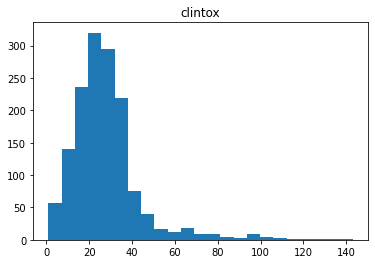

7831it [00:14, 556.70it/s]


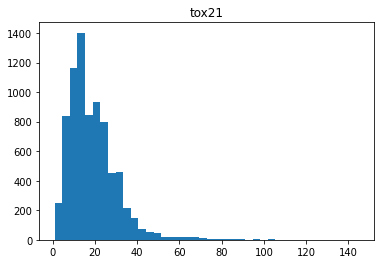

    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True)
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=T

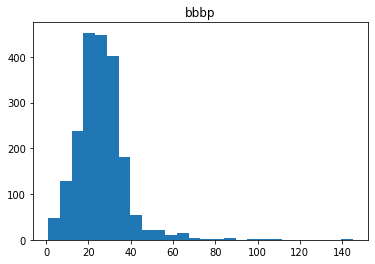

41127it [01:36, 425.86it/s]


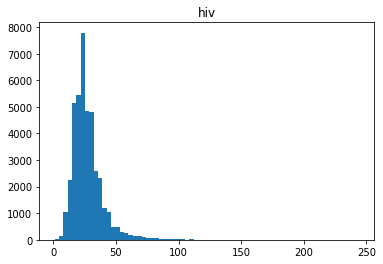

In [33]:
for dataset in ['clintox', 'tox21', 'bbbp', 'hiv']:
    if dataset == 'clintox':
        tasks, datasets, transformers = dc.molnet.load_clintox(reload=False, featurizer=dc.feat.RawFeaturizer(True), splitter=None)
    elif dataset == 'tox21':
        tasks, datasets, transformers = dc.molnet.load_tox21(reload=False, featurizer=dc.feat.RawFeaturizer(True), splitter=None)
    elif dataset == 'hiv':
        tasks, datasets, transformers = dc.molnet.load_hiv(reload=False, featurizer=dc.feat.RawFeaturizer(True), splitter=None)
    elif dataset == 'bbbp':
        tasks, datasets, transformers = dc.molnet.load_bbbp(reload=False, featurizer=dc.feat.RawFeaturizer(True), splitter=None)


    m_vertices = []
    m_edges = []
    for idx, smiles in tqdm.tqdm(enumerate(datasets[0].X)):
        d = smiles2graph(smiles, False, False, np.inf, np.inf)
        m_vertices += [d.atom_features.shape[0]]
        m_edges += [d.edge_index.shape[1]//2]

    plt.hist(m_edges, bins='rice')
    plt.title(dataset)
    plt.show()